In [1]:
import os
import cv2
import numpy as np
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt 
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.backend as ktf
from tensorflow.keras.models import load_model,Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model

from location.network import *
from recognition.network import *
from util import *
import cfg


## 模型载入

In [3]:
location_model = Location().location_network()
location_model.load_weights(cfg.location_weights)
location_model.summary()

_, recognition_model = CRNN(cfg.width, cfg.height, cfg.label_len, cfg.characters).network()
recognition_model.load_weights(cfg.recognition_weights)
recognition_model.summary()


Model: "LocationModel"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv0_0 (separableconv)         (None, 512, 512, 32) 1755        input_img[0][0]                  
__________________________________________________________________________________________________
conv0_1 (separableconv)         (None, 256, 256, 32) 2944        conv0_0[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv0_1[0][0]                    
______________________________________________________________________________________

ValueError: Shapes (8192, 256) and (4096, 256) are incompatible

## 可视化

In [ ]:
plot_model(location_model, to_file='EAST_Net.png')

In [ ]:
plot_model(recognition_model, to_file='CRNN_Net.png')

In [3]:
def conv_output(model,layer_name,img):
    input_img = model.input
    try:
        # this is the placeholder for the conv output
        out_conv = model.get_layer(layer_name).output
    except:
        raise Exception('Not layer named {}!'.format(layer_name))

    # get the intermediate layer model
    intermediate_layer_model = Model(inputs=input_img, outputs=out_conv)

    # get the output of intermediate layer model
    intermediate_output = intermediate_layer_model.predict(img)
    
    featurema_map=intermediate_output[0]
    return featurema_map


In [4]:
def vis_conv(images, n,t):
    """visualize conv output and conv filter.

    Args:
           img: original image.
           n: number of col and row.
           t: vis type.
           name: save name.
    """
    size = images.shape[0]
    margin = 0

    if t == 'filter':
        results = np.zeros((n * size + 7 * margin, n * size + 7 * margin, 3))
    if t == 'conv':
        results = np.zeros((n * size + 7 * margin, n * size + 7 * margin))

    for i in range(n):
        for j in range(n):
            if t == 'filter':
                filter_img = images[i + (j * n)]
            if t == 'conv':
                filter_img = images[..., i + (j * n)]
            filter_img = cv2.resize(filter_img, (size, size))

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            if t == 'filter':
                results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
            if t == 'conv':
                results[horizontal_start: horizontal_end, vertical_start: vertical_end] = filter_img

    # Display the results grid
    return results

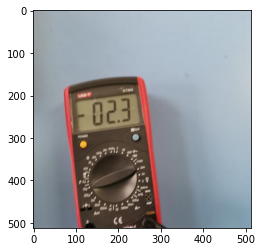

In [5]:
img = image.load_img(r'location\test_imgs/500.jpg')
d_wight, d_height = resize_image(img, cfg.image_size)
img = img.resize((d_wight, d_height), Image.NEAREST).convert('RGB')
plt.imshow(img)
img = image.img_to_array(img)
img = img/255*2-1
x = np.expand_dims(img, axis=0)

In [40]:
for index,layer in enumerate(location_model.layers):
    print(index,layer.name)

0 input_img
1 conv0_0
2 conv0_1
3 max_pooling2d
4 conv1
5 shortcut1_1
6 scon1
7 shortcut1_2
8 add
9 conv2
10 shortcut2_0
11 scon2
12 shortcut2_1
13 add_1
14 conv3
15 shortcut3_0
16 scon3
17 shortcut3_1
18 add_2
19 conv2d_transpose
20 merge1
21 batch_normalization_28
22 separableconv
23 attention1
24 dropout
25 conv2d_transpose_1
26 merge2
27 batch_normalization_31
28 separableconv_1
29 attention2
30 dropout_1
31 conv2d_transpose_2
32 merge3
33 batch_normalization_34
34 separableconv_2
35 attention3
36 dropout_2
37 conv2d_3
38 inside_score
39 side_vertex_code
40 side_vertex_coord
41 detection


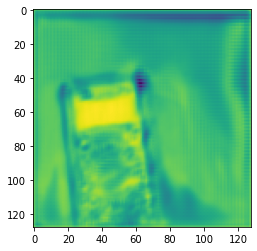

In [12]:
layer_name='inside_score'
#layer_name='block4_pool'
#layer_name='up_sampling2d_2'
#layer_name='conv2d_6'
#layer_name='concatenate_1'
#layer_name='att'
#layer_name='inside_score'
#layer_name='side_vertex_code'
#layer_name='side_vertex_coord'
cout=conv_output(location_model,layer_name,x)
feamap=vis_conv(cout,1,'conv')
plt.imshow(feamap)

In [ ]:
plt.figure(figsize=(5,5))
for i in range(2,5):
    layer_name='block'+str(i)+'_pool'
    cout=conv_output(location_model,layer_name,x)
    y=cout[:,:,9:12]
    
    plt.subplot(1,5,i+1)
    plt.title(layer_name)
    plt.xlabel('off')
    plt.imshow(y)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


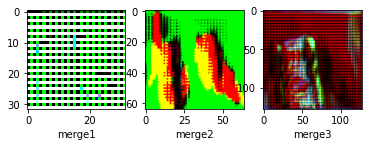

In [27]:
n=3
for i in range(n):
    layer_name='merge'+str(i+1)
    y=conv_output(location_model,layer_name,x)[:,:,6:9]
    #plt.figure(dpi=50)
    #plt.figure(figsize=(10,10),dpi=100)
    #plt.figure(i+1,figsize=(10,10),dpi=600)
    plt.subplot(1,n,i+1)

    plt.xlabel(layer_name)
    plt.imshow(y)
    #plt.show()